# Calculate velocity from $SSH_{BC}$

The governing equations for baroclinic velocity are (Zaron, 2019)

$$
-i \omega u  - fv = -g  \eta_x - u/\tau
$$

$$
-i \omega v  + fu = -g  \eta_y - v/\tau
$$

where $u$, $v$, $\eta$ are the complex harmonic amplitudes for each frequency, $\omega$. $\tau$ is a damping time scale that we will assume to be large so that we can ignore the last term. Subscripts $x$ and $y$ denote a partial derivative.

Solutions for $u$ and $v$ given $\eta$ are (González-Haro et al., 2020)

$$
u = \frac{-i\omega_T g \eta_x + f g \eta_y}{\omega_T^2 - f^2}
$$
$$
v = \frac{ - f g \eta_x-i\omega_T g \eta_y}{\omega_T^2 - f^2}
$$
and $\omega_T=\omega+i/\tau \approx \omega$.

The steps to compute a velocity time-series are:

1. Calculate the spatial gradients of the real and imaginary amplitudes for $\eta$ for each frequency
2. Compute the complex velocity using expressions above
3. Reconstruct a time-series from the harmonics

For a single-point:
 - Interpolate $\eta$ amplitudes onto a 3x3 grid around each point
 - Do steps 1 - 3 above

---
## References

González-Haro, C., Ponte, A. & Autret, E. Quantifying tidal fluctuations in remote sensing infrared SST observations. *Remote Sens.* 11, 1–14 (2019).

Zaron, E. D. Baroclinic tidal sea level from exact-repeat mission altimetry. *J. Phys. Oceanogr.* 49, 193–210 (2019).

In [1]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas import sshdriver
from iwatlas import harmonics
from iwatlas import stratification as strat
from iwatlas import iwaves

import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

In [2]:
def calc_coriolis(latdeg):
    omega = 2*np.pi/86400.
    degrad = np.pi/180.
    return 2*omega*np.sin(latdeg*degrad)

def calc_u_complex(eta_x, eta_y, omega, f, g=9.81, tau=1e6):
    omegaT = omega + 1j/tau
    num = -1j*omegaT*g*eta_x + f*g*eta_y
    den = omegaT**2. - f**2.
    return num/den

def calc_v_complex(eta_x, eta_y, omega, f, g=9.81, tau=1e6):
    omegaT = omega + 1j/tau
    num = -1j*omegaT*g*eta_y - f*g*eta_x
    den = omega**2. - f**2.
    return num/den

def extract_hc_uv_spatial(sshfile):
    """
    Compute the complex u and v amplitude matrices
    """
    ssh = sshdriver.load_ssh_clim(sshfile)
    
    # Step 1: compute the spatial gradients of eta
    omega = ssh._ds['omega'].values
    f_cor = calc_coriolis(ssh.yv)

    ntide = omega.shape[0]

    # Load the full matrix
    eta_re = ssh._ds['SSH_BC_Aa'][...].values
    eta_im = ssh._ds['SSH_BC_Ba'][...].values

    # Calculate the coriolis
    f_cor = calc_coriolis(ssh.yv)

    u = np.zeros((ntide,ssh.Nc), np.complex128)
    v = np.zeros((ntide,ssh.Nc), np.complex128)

    for ii in range(ntide):
        eta_re_dx, eta_re_dy = ssh.calc_grad(eta_re[ii,:])
        eta_im_dx, eta_im_dy = ssh.calc_grad(eta_im[ii,:])

        u[ii,:] = calc_u_complex(eta_re_dx+1j*eta_im_dx, eta_re_dy+1j*eta_im_dy, omega[ii], f_cor)
        v[ii,:] = calc_v_complex(eta_re_dx+1j*eta_im_dx, eta_re_dy+1j*eta_im_dy, omega[ii], f_cor)
        
    return u, v, omega


In [13]:
def predict_uv(sshfile, x, y, time, kind='linear'):
    """
    Perform harmonic predictions of the u/v velocity amplitude at the points in x and y and time
    """
    ssh = sshdriver.load_ssh_clim(sshfile)
    
    # Calculate complex velocity amplitudes from ssh
    u,v, omega = extract_hc_uv_spatial(ssh)
    
    # Mean velocity is zero
    a0 = np.zeros((ssh.Nc,))
    
    # Interpolate the amplitudes in space and reconstruct the time-series
    aa, Aa, Ba, frq = sshdriver.extract_amp_xy(ssh, xpt, ypt, a0, np.real(u), np.imag(u), kind=kind )
    ut = sshdriver.predict_scalar( time, aa, Aa, Ba, omega)

    aa, Aa, Ba, frq = sshdriver.extract_amp_xy(ssh, xpt, ypt, a0, np.real(v), np.imag(v), kind=kind )
    vt = sshdriver.predict_scalar( time, aa, Aa, Ba, omega)
    
    return ut, vt

def predict_uv_z(sshfile, x, y, time, nz=80, mode=0, kind='linear'):
    """
    Predict the full-depth profile velocity
    """
    
    ssh = sshdriver.load_ssh_clim(sshfile)
    
    ut, vt = predict_uv(ssh, x, y, time, kind=kind)

    # Only compute N^2 at a few time steps
    N2_z, zout = strat.predict_N2(ssh, x, y, time, nz)
    
    # Mode shapes
    phi_n, cn = iwaves.calc_modes(N2_z, zout, mode=mode)
    
    # Calculate the vertical gradient of the modal structure function and normalize
    dphi_dz = iwaves.grad_z(phi_n, zout)
    dphi_dz_norm = dphi_dz/ dphi_dz.max(axis=0)[None,...]
    
    # Compute the velocity profile
    uz = dphi_dz_norm * ut.T 
    vz = dphi_dz_norm * vt.T 
    
    return uz, vz, zout


In [4]:
basedir = '../DATA'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

In [5]:
ssh = sshdriver.load_ssh_clim(atlasfile)
ssh

<xarray.Dataset>
Dimensions:     (Nannual: 4, Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Nparams: 7, Ntide: 35, numsides: 8)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79 79
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nannual, Nc, Nkw, Nmode, Np, Nparams, Ntide, numsides
Data variables:
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    dz          (Nk) float64 ...
    z_r         (Nk) float64 ...
    N2_mu       (Nparams, Nc) float64 ...
    N2_re       (Nannual

In [6]:
ssh.Ac.max()

330076168.85546875

In [7]:
# # Step 1: compute the spatial gradients of eta
# omega = ssh._ds['omega'].values
# f_cor = calc_coriolis(ssh.yv)

# ntide = omega.shape[0]

# # Load the full matrix
# eta_re = ssh._ds['SSH_BC_Aa'][...].values
# eta_im = ssh._ds['SSH_BC_Ba'][...].values

# # Calculate the coriolis
# f_cor = calc_coriolis(ssh.yv)

# u = np.zeros((ntide,ssh.Nc), np.complex128)
# v = np.zeros((ntide,ssh.Nc), np.complex128)

# for ii in range(ntide):
#     eta_re_dx, eta_re_dy = ssh.calc_grad(eta_re[ii,:])
#     eta_im_dx, eta_im_dy = ssh.calc_grad(eta_im[ii,:])

#     u[ii,:] = calc_u_complex(eta_re_dx+1j*eta_im_dx, eta_re_dy+1j*eta_im_dy, omega[ii], f_cor)
#     v[ii,:] = calc_v_complex(eta_re_dx+1j*eta_im_dx, eta_re_dy+1j*eta_im_dy, omega[ii], f_cor)
u,v, omega = extract_hc_uv_spatial(ssh)

(<Figure size 864x432 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fe883496550>)

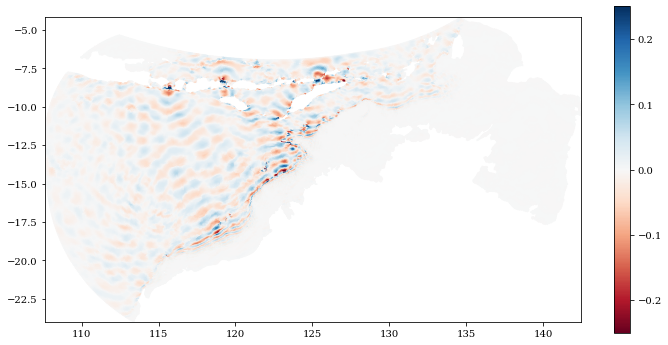

In [8]:
plt.figure(figsize=(12,6))
ssh.plotcelldata(np.imag(v[10,:]) , cmap='RdBu', vmin=-0.25, vmax=0.25)

In [11]:
# Do a time-series prediction of the amplitude (Note that this needs to be multiplied by the modal function gradient to get u(z))

xpt = 123.3506
ypt = -13.7641
# Create a time vector
dt = 1800
numdays = 30
tstart = np.datetime64('2020-11-01 00:00:00')


nsteps = numdays*86400//dt
timeout = np.array([tstart+np.timedelta64(ii*dt,'s') for ii in range(nsteps)])

ut, vt = predict_uv(ssh, np.array([xpt]), np.array([ypt]), timeout)
# # Mean velocity is zero
# a0 = np.zeros((ssh.Nc,))

# aa, Aa, Ba, frq = sshdriver.extract_amp_xy(ssh, np.array([xpt]), np.array([ypt]), a0, np.real(u), np.imag(u) )
# ut = sshdriver.predict_scalar( timeout, aa, Aa, Ba, frq)

# aa, Aa, Ba, frq = sshdriver.extract_amp_xy(ssh, np.array([xpt]), np.array([ypt]), a0, np.real(v), np.imag(v) )
# vt = sshdriver.predict_scalar( timeout, aa, Aa, Ba, frq)


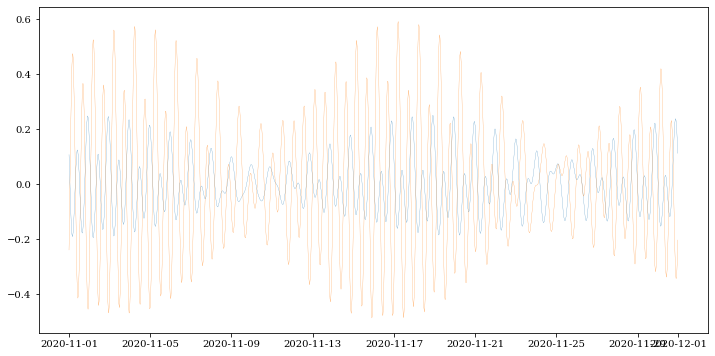

In [12]:
plt.figure(figsize=(12,6))
plt.plot(timeout, ut, lw=0.2)
plt.plot(timeout, vt, lw=0.2)

In [14]:
uz, vz, zout = predict_uv_z(ssh, np.array([xpt]), np.array([ypt]), timeout)

/home/suntans/code/iwatlas/iwatlas/stratification.py:94: RuntimeWarning: divide by zero encountered in log
  zpr = -np.log(zout)


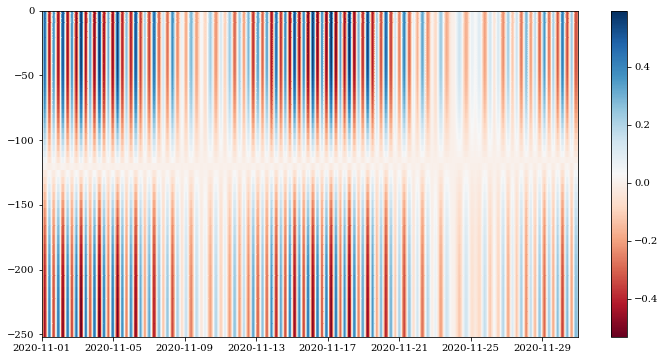

In [15]:
plt.figure(figsize=(12,6))
plt.pcolormesh(timeout, -zout[:,0,0].squeeze(), vz.squeeze(), cmap='RdBu')
plt.colorbar()

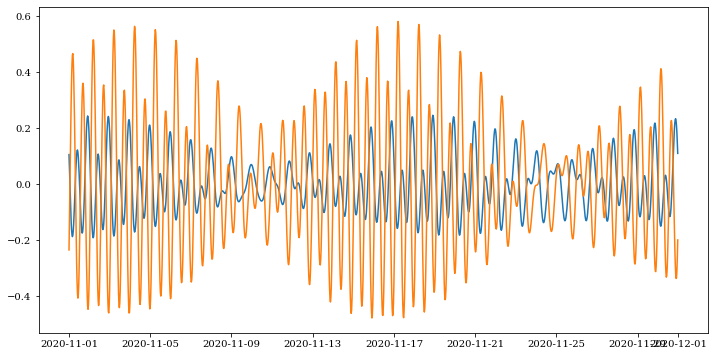

In [19]:
# Plot the surface velocity
usurf = uz[0,0,...]
vsurf = vz[0,0,...]

plt.figure(figsize=(12,6))
plt.plot(timeout, usurf)
plt.plot(timeout, vsurf)

In [10]:
# Calculate the structure function so that we can compute velocity with depth
nz = 80 # Number of vertical layers to output

# Call the predict_N2 method. Note that this function expects numpy arrays, not scalars, for all inputs

# Only compute N^2 at a few time steps
N2_z, zout = strat.predict_N2(ssh, np.array([xpt]), np.array([ypt]), timeout, nz)

/home/suntans/code/iwatlas/iwatlas/stratification.py:94: RuntimeWarning: divide by zero encountered in log
  zpr = -np.log(zout)


In [11]:
%%time
# Calculate the internal wave parameters
mode= 0 

# Mode shapes
phi_n, cn = iwaves.calc_modes(N2_z, zout, mode=mode)

CPU times: user 12.8 s, sys: 87.4 ms, total: 12.9 s
Wall time: 13 s


In [12]:
dphi_dz = iwaves.grad_z(phi_n, zout)
dphi_dz_norm = dphi_dz/ dphi_dz.max(axis=0)[None,...]
dphi_dz.shape

(80, 1, 1440)

In [13]:
uz = dphi_dz_norm * ut.T 
vz = dphi_dz_norm * vt.T 

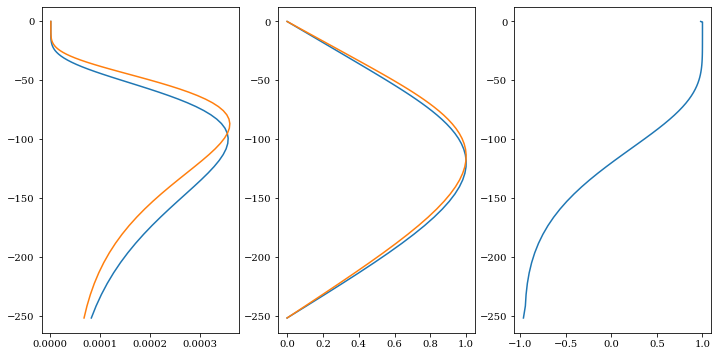

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(N2_z[:,0,0], -zout[:,0,0])
plt.plot(N2_z[:,0,-1], -zout[:,0,-1])

plt.subplot(132)
plt.plot(phi_n[:,0,0], -zout[:,0,0])
plt.plot(phi_n[:,0,-1], -zout[:,0,-1])

plt.subplot(133)
plt.plot(dphi_dz_norm[:,0,0], -zout[:,0,0])